Mount Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
import zipfile
import os

zip_path = "/content/drive/MyDrive/Speech_dataset_audio_files_final.zip"
extract_path = "/content/lectures"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Recursively find all .wav files
audio_files = []
for root, dirs, files in os.walk(extract_path):
    for file in files:
        if file.endswith('.wav'):
            audio_files.append(os.path.join(root, file))

print(f"Found {len(audio_files)} audio files:")
for f in audio_files:
    print(f)


Found 6 audio files:
/content/lectures/Speech_dataset_audio_files_final/phonetics_high_res_audio.wav
/content/lectures/Speech_dataset_audio_files_final/psychology_high_res_audio.wav
/content/lectures/Speech_dataset_audio_files_final/physics_high_res_audio.wav
/content/lectures/Speech_dataset_audio_files_final/short_range_MIT_audio.wav
/content/lectures/Speech_dataset_audio_files_final/cities_and_decarbonization_standard_res_audio.wav
/content/lectures/Speech_dataset_audio_files_final/creating_breakthrough_products_MIT.wav


In [3]:
!pip install noisereduce scipy librosa


In [4]:
!pip install noisereduce pydub librosa soundfile
!apt-get install ffmpeg


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.


# **Denoising + Normalizing + Cleaning**

In [5]:
import os
import librosa
import noisereduce as nr
import soundfile as sf
from pydub import AudioSegment

# Paths
input_path = "/content/lectures/Speech_dataset_audio_files_final"
output_path = "/content/cleaned_audio"
os.makedirs(output_path, exist_ok=True)

# List .wav files
audio_files = [f for f in os.listdir(input_path) if f.endswith(".wav")]

# Track whether temp file was created
temp_path = None

for file in audio_files:
    print(f"Processing: {file}")

    # Load audio with librosa
    audio_path = os.path.join(input_path, file)
    y, sr = librosa.load(audio_path, sr=None)

    # Denoise
    noise_sample = y[:int(sr * 0.5)]  # First 0.5 seconds as noise
    denoised = nr.reduce_noise(y=y, sr=sr, y_noise=noise_sample)

    # Save temp denoised file
    temp_path = os.path.join(output_path, "temp.wav")
    sf.write(temp_path, denoised, sr)

    # Normalize using pydub
    audio = AudioSegment.from_wav(temp_path)
    normalized_audio = audio.apply_gain(-audio.max_dBFS)

    # Save final cleaned file
    final_path = os.path.join(output_path, file)
    normalized_audio.export(final_path, format="wav")

    print(f"✅ Saved: {final_path}")

# Clean up temp file if it was created
if temp_path and os.path.exists(temp_path):
    os.remove(temp_path)
    print("🧹 Temp file deleted.")

print("\n🎉 All files processed successfully.")


Processing: phonetics_high_res_audio.wav
✅ Saved: /content/cleaned_audio/phonetics_high_res_audio.wav
Processing: psychology_high_res_audio.wav


/usr/local/lib/python3.11/dist-packages/noisereduce/spectralgate/nonstationary.py:70: RuntimeWarning: invalid value encountered in divide
  sig_mult_above_thresh = (abs_sig_stft - sig_stft_smooth) / sig_stft_smooth


✅ Saved: /content/cleaned_audio/psychology_high_res_audio.wav
Processing: physics_high_res_audio.wav
✅ Saved: /content/cleaned_audio/physics_high_res_audio.wav
Processing: short_range_MIT_audio.wav
✅ Saved: /content/cleaned_audio/short_range_MIT_audio.wav
Processing: cities_and_decarbonization_standard_res_audio.wav
✅ Saved: /content/cleaned_audio/cities_and_decarbonization_standard_res_audio.wav
Processing: creating_breakthrough_products_MIT.wav
✅ Saved: /content/cleaned_audio/creating_breakthrough_products_MIT.wav
🧹 Temp file deleted.

🎉 All files processed successfully.


# **Transcribe Cleaned Audio Files with Whisper**

In [6]:
!pip install -q openai-whisper


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 800.5/800.5 kB 11.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 58.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 64.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 107.5 MB

In [ ]:

import whisper
import os

# Load Whisper model (base is fast; medium/large for better accuracy)
model = whisper.load_model("medium")

# Get list of cleaned audio files
cleaned_path = "/content/cleaned_audio"
cleaned_files = [f for f in os.listdir(cleaned_path) if f.endswith('.wav')]

# Output directory for JSON results
output_dir = "/content/transcriptions"
os.makedirs(output_dir, exist_ok=True)

# Transcribe each file
for file in cleaned_files:
    audio_path = os.path.join(cleaned_path, file)
    print(f"🔍 Transcribing {file}...")

    result = model.transcribe(audio_path)

    # Save full transcription with timestamps
    base_name = os.path.splitext(file)[0]
    output_file = os.path.join(output_dir, f"{base_name}_transcription.json")

    import json

    with open(output_file, "w") as f:
        json.dump(result, f)

    print(f"✅ Transcription saved to {output_file}")


🔍 Transcribing physics_high_res_audio.wav...
✅ Transcription saved to /content/transcriptions/physics_high_res_audio_transcription.json
🔍 Transcribing psychology_high_res_audio.wav...
✅ Transcription saved to /content/transcriptions/psychology_high_res_audio_transcription.json
🔍 Transcribing creating_breakthrough_products_MIT.wav...
✅ Transcription saved to /content/transcriptions/creating_breakthrough_products_MIT_transcription.json
🔍 Transcribing cities_and_decarbonization_standard_res_audio.wav...
✅ Transcription saved to /content/transcriptions/cities_and_decarbonization_standard_res_audio_transcription.json
🔍 Transcribing phonetics_high_res_audio.wav...
✅ Transcription saved to /content/transcriptions/phonetics_high_res_audio_transcription.json
🔍 Transcribing short_range_MIT_audio.wav...
✅ Transcription saved to /content/transcriptions/short_range_MIT_audio_transcription.json


In [ ]:
import shutil

shutil.make_archive("/content/transcriptions", 'zip', "/content/transcriptions")


'/content/transcriptions.zip'

In [ ]:
from google.colab import files
files.download("/content/transcriptions.zip")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# **Speech Features Extraction**


In [ ]:
!pip install praat-parselmouth librosa


In [ ]:
import os
import zipfile

# Define the paths for your folders
cleaned_audio_path = "/content/cleaned_audio"
transcriptions_zip_path = "/content/transcriptions.zip"  # Path to the zip file
transcriptions_path = "/content/transcriptions"  # Folder where transcriptions will be extracted

# Extract the zip file if it hasn't been extracted already
if not os.path.exists(transcriptions_path):
    os.makedirs(transcriptions_path)
    with zipfile.ZipFile(transcriptions_zip_path, 'r') as zip_ref:
        zip_ref.extractall(transcriptions_path)
    print(f"Extracted transcriptions to {transcriptions_path}")

# List contents of cleaned audio folder
cleaned_audio_files = [f for f in os.listdir(cleaned_audio_path) if os.path.isfile(os.path.join(cleaned_audio_path, f))]
print("Files in 'cleaned_audio' folder:", cleaned_audio_files)

# List contents of transcriptions folder
transcriptions_files = [f for f in os.listdir(transcriptions_path) if os.path.isfile(os.path.join(transcriptions_path, f))]
print("Files in 'transcriptions' folder:", transcriptions_files)


Files in 'cleaned_audio' folder: ['physics_high_res_audio.wav', 'psychology_high_res_audio.wav', 'creating_breakthrough_products_MIT.wav', 'cities_and_decarbonization_standard_res_audio.wav', 'phonetics_high_res_audio.wav', 'short_range_MIT_audio.wav']
Files in 'transcriptions' folder: ['physics_high_res_audio_transcription.json', 'phonetics_high_res_audio_transcription.json', 'cities_and_decarbonization_standard_res_audio_transcription.json', 'short_range_MIT_audio_transcription.json', 'creating_breakthrough_products_MIT_transcription.json', 'psychology_high_res_audio_transcription.json']


In [ ]:
!pip install praat-parselmouth


In [ ]:
!pip install openai-whisper


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 800.5/800.5 kB 6.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 56.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 127.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 96.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 58.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s 

In [ ]:
import whisper
import librosa
import numpy as np
import pandas as pd
import parselmouth
from parselmouth.praat import call
import os
import json

# Load Whisper model (base is fast; medium/large for better accuracy)
model = whisper.load_model("medium")

# Define paths
cleaned_audio_path = "/content/cleaned_audio"
transcriptions_path = "/content/transcriptions"
output_csv_path = "/content/segment_level_features.csv"

# Function to extract prosodic features
def extract_prosodic_features(y_seg, sr):
    pitch, _, _ = librosa.pyin(y_seg, fmin=librosa.note_to_hz('C2'), fmax=librosa.note_to_hz('C7'))
    pitch_mean = np.nanmean(pitch) if pitch is not None and not np.all(np.isnan(pitch)) else 0
    pitch_std = np.nanstd(pitch) if pitch is not None and not np.all(np.isnan(pitch)) else 0
    energy = np.sum(y_seg ** 2) / len(y_seg) if len(y_seg) > 0 else 0
    return {
        "pitch_mean": pitch_mean,
        "pitch_std": pitch_std,
        "energy": energy
    }

# Function to extract phonation & formant features
def extract_phonation_formant_features(y_seg, sr):
    snd = parselmouth.Sound(y_seg, sampling_frequency=sr)
    try:
        point_process = call(snd, "To PointProcess (periodic, cc)", 75, 500)
        jitter = call(point_process, "Get jitter (local)", 0, 0, 0.0001, 0.02, 1.3)
        shimmer = call([snd, point_process], "Get shimmer (local)", 0, 0, 0.0001, 0.02, 1.3, 1.6)
    except:
        jitter = shimmer = 0

    try:
        harmonicity = call(snd, "To Harmonicity (cc)", 0.01, 75, 0.1, 1.0)
        hnr = call(harmonicity, "Get mean", 0, 0)
    except:
        hnr = 0

    try:
        formant = call(snd, "To Formant (burg)", 0.02, 5, 5500, 0.025, 50)
        f1 = call(formant, "Get mean", 1, 0, 0, "Hertz")
        f2 = call(formant, "Get mean", 2, 0, 0, "Hertz")
        f3 = call(formant, "Get mean", 3, 0, 0, "Hertz")
    except:
        f1 = f2 = f3 = 0

    return {
        "jitter_local": jitter,
        "shimmer_local": shimmer,
        "hnr": hnr,
        "formant_F1": f1,
        "formant_F2": f2,
        "formant_F3": f3
    }

# Function to extract spectral features
def extract_spectral_features(y_seg, sr):
    mfccs = librosa.feature.mfcc(y=y_seg, sr=sr, n_mfcc=13)
    mfcc_mean = np.mean(mfccs, axis=1)
    rolloff = librosa.feature.spectral_rolloff(y=y_seg, sr=sr)[0]
    flatness = librosa.feature.spectral_flatness(y=y_seg)[0]

    return {
        **{f"mfcc_{i+1}": mfcc_mean[i] for i in range(len(mfcc_mean))},
        "spectral_rolloff_mean": np.mean(rolloff),
        "spectral_flatness_mean": np.mean(flatness)
    }

# Function to extract temporal features
def extract_temporal_features(text, duration):
    words = text.strip().split()
    num_words = len(words)
    num_chars = len(text.replace(" ", ""))
    return {
        "num_words": num_words,
        "num_chars": num_chars,
        "speech_rate": num_words / duration if duration > 0 else 0,
        "articulation_rate": num_chars / duration if duration > 0 else 0
    }

# Function to combine all feature types
def extract_all_features(y, sr, start, end, text):
    start_sample = int(start * sr)
    end_sample = int(end * sr)
    y_seg = y[start_sample:end_sample]

    return {
        **extract_prosodic_features(y_seg, sr),
        **extract_phonation_formant_features(y_seg, sr),
        **extract_spectral_features(y_seg, sr),
        **extract_temporal_features(text, end - start)
    }

# Function to extract features for all segments of a single file
def extract_features_for_all_segments(y, sr, segments, lecture_id):
    data = []
    for seg in segments:
        features = extract_all_features(y, sr, seg["start"], seg["end"], seg["text"])
        entry = {
            "lecture_id": lecture_id,
            "segment_id": seg["id"],
            "start": seg["start"],
            "end": seg["end"],
            "duration": seg["end"] - seg["start"],
            "text": seg["text"],
            **features
        }
        data.append(entry)
    return pd.DataFrame(data)

# Process all audio files
feature_data = []
for file in cleaned_audio_files:
    audio_path = os.path.join(cleaned_audio_path, file)
    transcription_path = os.path.join(transcriptions_path, f"{os.path.splitext(file)[0]}_transcription.json")

    if not os.path.exists(transcription_path):
        print(f"❌ Skipping {file} (missing JSON)")
        continue

    with open(transcription_path, "r") as f:
        transcription = json.load(f)

    # Get lecture_id from file name (e.g., use the base name of the file)
    lecture_id = os.path.splitext(file)[0]

    # Load audio file
    y, sr = librosa.load(audio_path, sr=None)

    # Extract features for each segment based on Whisper transcription
    segments = transcription['segments']
    df = extract_features_for_all_segments(y, sr, segments, lecture_id)

    # Add the features for this file
    feature_data.append(df)

# Combine all feature data into a single DataFrame
final_df = pd.concat(feature_data, ignore_index=True)

# Save the combined features to CSV
final_df.to_csv(output_csv_path, index=False)
print(f"✅ Feature extraction complete. CSV saved at: {output_csv_path}")


✅ Feature extraction complete. CSV saved at: /content/segment_level_features.csv


AttributeError: 'list' object has no attribute 'download'

In [2]:
final_df = pd.read_csv("/content/segment_level_features.csv")

In [3]:
final_df

,lecture_id,segment_id,start,end,duration,text,pitch_mean,pitch_std,energy,jitter_local,...,mfcc_10,mfcc_11,mfcc_12,mfcc_13,spectral_rolloff_mean,spectral_flatness_mean,num_words,num_chars,speech_rate,articulation_rate
0,physics_high_res_audio,0,0.00,19.96,19.96,"Okay, welcome everyone. Welcome back to 8.225...",589.338240,494.539109,0.002306,0.025186,...,-7.052330,-3.911952,0.751835,-2.683685,2335.649539,0.436113,16,74,0.801603,3.707415
1,physics_high_res_audio,1,19.96,24.92,4.96,"Century. Let me start by asking just quickly,...",224.857467,60.733922,0.006648,0.023942,...,-20.518536,-11.112197,1.120351,-13.066287,3300.180288,0.053642,15,76,3.024194,15.322581
2,physics_high_res_audio,2,24.92,28.48,3.56,"of course structure, other questions like tha...",1254.579348,267.370082,0.003710,0.023884,...,-8.967247,-9.217199,5.261159,-6.404652,2967.006138,0.061575,16,72,4.494382,20.224719
3,physics_high_res_audio,3,28.48,33.44,4.96,we'll jump into the first main lecture. In ge...,207.645169,49.878002,0.003653,0.023230,...,-15.486810,-9.401155,1.504241,-10.604864,2935.296474,0.161827,17,73,3.427419,14.717742
4,physics_high_res_audio,4,33.44,39.80,6.36,to skim the more technical readings before th...,210.260485,57.657557,0.003647,0.027459,...,-15.244900,-5.827204,1.232816,-9.872044,3716.472990,0.031274,15,71,2.358491,11.163522
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5213,short_range_MIT_audio,473,3751.32,3757.84,6.52,they have to wait longer. So we would allow a...,331.065022,207.999908,0.000507,0.013798,...,-5.492641,2.150913,-4.215773,-2.097696,2550.551471,0.007020,18,69,2.760736,10.582822
5214,short_range_MIT_audio,474,3757.84,3764.84,7.00,"we would avoid situations like that. Okay, so...",812.333579,654.898040,0.000078,0.015853,...,-1.345420,-2.038093,-2.395886,-1.158675,2456.549658,0.411186,16,72,2.285714,10.285714
5215,short_range_MIT_audio,475,3771.60,3778.60,7.00,"to the rest of the guidelines, particularly w...",304.282807,182.657918,0.000687,0.012467,...,-7.624669,0.991366,-6.330200,-3.622454,2758.989726,0.011557,13,70,1.857143,10.000000
5216,short_range_MIT_audio,476,3778.60,3785.60,7.00,"Sorry? That's a good question. Yeah, better. ...",694.330943,609.538436,0.000140,0.012888,...,-1.665980,-1.466708,-1.801567,-2.241957,3998.466039,0.024822,15,75,2.142857,10.714286


In [ ]:
import os
import json
import pandas as pd

# Paths
transcriptions_path = "/content/transcriptions"
features_csv_path = "/content/segment_level_features.csv"
merged_output_path = "/content/merged_segment_features.csv"

# Load speech features CSV
features_df = pd.read_csv(features_csv_path)

# List all transcription files
transcription_files = [f for f in os.listdir(transcriptions_path) if f.endswith("_transcription.json")]

# Collect all Whisper segment metadata
whisper_data = []

for file in transcription_files:
    lecture_id = file.replace("_transcription.json", "")
    with open(os.path.join(transcriptions_path, file), "r") as f:
        transcription = json.load(f)
        for seg in transcription["segments"]:
            whisper_data.append({
                "lecture_id": lecture_id,
                "segment_id": seg["id"],
                "whisper_start": seg["start"],
                "whisper_end": seg["end"],
                "whisper_text": seg["text"],
                "whisper_confidence": seg.get("confidence", None),
                "whisper_tokens": seg.get("tokens", None),
                "whisper_avg_logprob": seg.get("avg_logprob", None),
                "whisper_compression_ratio": seg.get("compression_ratio", None),
                "whisper_no_speech_prob": seg.get("no_speech_prob", None)
            })

# Create a DataFrame from Whisper metadata
whisper_df = pd.DataFrame(whisper_data)

# Merge on lecture_id and segment_id
merged_df = pd.merge(features_df, whisper_df, on=["lecture_id", "segment_id"], how="left")

# Save to CSV
merged_df.to_csv(merged_output_path, index=False)
print(f"✅ Merged CSV saved to: {merged_output_path}")


✅ Merged CSV saved to: /content/merged_segment_features.csv


In [2]:
import pandas as pd
merged_df = pd.read_csv("/content/merged_segment_features.csv")

In [7]:
merged_df


,lecture_id,segment_id,start,end,duration,text,pitch_mean,pitch_std,energy,jitter_local,...,speech_rate,articulation_rate,whisper_start,whisper_end,whisper_text,whisper_confidence,whisper_tokens,whisper_avg_logprob,whisper_compression_ratio,whisper_no_speech_prob
0,physics_high_res_audio,0,0.00,19.96,19.96,"Okay, welcome everyone. Welcome back to 8.225...",589.338240,494.539109,0.002306,0.025186,...,0.801603,3.707415,0.00,19.96,"Okay, welcome everyone. Welcome back to 8.225...",NaN,"[50364, 1033, 11, 2928, 1518, 13, 4027, 646, 2...",-0.312713,1.417989,0.080139
1,physics_high_res_audio,1,19.96,24.92,4.96,"Century. Let me start by asking just quickly,...",224.857467,60.733922,0.006648,0.023942,...,3.024194,15.322581,19.96,24.92,"Century. Let me start by asking just quickly,...",NaN,"[51362, 28555, 13, 961, 385, 722, 538, 3365, 4...",-0.312713,1.417989,0.080139
2,physics_high_res_audio,2,24.92,28.48,3.56,"of course structure, other questions like tha...",1254.579348,267.370082,0.003710,0.023884,...,4.494382,20.224719,24.92,28.48,"of course structure, other questions like tha...",NaN,"[51610, 295, 1164, 3877, 11, 661, 1651, 411, 3...",-0.312713,1.417989,0.080139
3,physics_high_res_audio,3,28.48,33.44,4.96,we'll jump into the first main lecture. In ge...,207.645169,49.878002,0.003653,0.023230,...,3.427419,14.717742,28.48,33.44,we'll jump into the first main lecture. In ge...,NaN,"[50364, 321, 603, 3012, 666, 264, 700, 2135, 7...",-0.212382,1.638060,0.775933
4,physics_high_res_audio,4,33.44,39.80,6.36,to skim the more technical readings before th...,210.260485,57.657557,0.003647,0.027459,...,2.358491,11.163522,33.44,39.80,to skim the more technical readings before th...,NaN,"[50612, 281, 1110, 332, 264, 544, 6191, 27319,...",-0.212382,1.638060,0.775933
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5213,short_range_MIT_audio,473,3751.32,3757.84,6.52,they have to wait longer. So we would allow a...,331.065022,207.999908,0.000507,0.013798,...,2.760736,10.582822,3751.32,3757.84,they have to wait longer. So we would allow a...,NaN,"[51218, 436, 362, 281, 1699, 2854, 13, 407, 32...",-0.214567,1.427419,0.008058
5214,short_range_MIT_audio,474,3757.84,3764.84,7.00,"we would avoid situations like that. Okay, so...",812.333579,654.898040,0.000078,0.015853,...,2.285714,10.285714,3757.84,3764.84,"we would avoid situations like that. Okay, so...",NaN,"[50364, 321, 576, 5042, 6851, 411, 300, 13, 10...",-0.301478,1.328125,0.002471
5215,short_range_MIT_audio,475,3771.60,3778.60,7.00,"to the rest of the guidelines, particularly w...",304.282807,182.657918,0.000687,0.012467,...,1.857143,10.000000,3771.60,3778.60,"to the rest of the guidelines, particularly w...",NaN,"[51052, 281, 264, 1472, 295, 264, 12470, 11, 4...",-0.301478,1.328125,0.002471
5216,short_range_MIT_audio,476,3778.60,3785.60,7.00,"Sorry? That's a good question. Yeah, better. ...",694.330943,609.538436,0.000140,0.012888,...,2.142857,10.714286,3778.60,3785.60,"Sorry? That's a good question. Yeah, better. ...",NaN,"[50364, 4919, 30, 663, 311, 257, 665, 1168, 13...",-0.443132,1.088235,0.092415


In [4]:
merged_df.columns

Index(['lecture_id', 'segment_id', 'start', 'end', 'duration', 'text',
       'pitch_mean', 'pitch_std', 'energy', 'jitter_local', 'shimmer_local',
       'hnr', 'formant_F1', 'formant_F2', 'formant_F3', 'mfcc_1', 'mfcc_2',
       'mfcc_3', 'mfcc_4', 'mfcc_5', 'mfcc_6', 'mfcc_7', 'mfcc_8', 'mfcc_9',
       'mfcc_10', 'mfcc_11', 'mfcc_12', 'mfcc_13', 'spectral_rolloff_mean',
       'spectral_flatness_mean', 'num_words', 'num_chars', 'speech_rate',
       'articulation_rate', 'whisper_start', 'whisper_end', 'whisper_text',
       'whisper_confidence', 'whisper_tokens', 'whisper_avg_logprob',
       'whisper_compression_ratio', 'whisper_no_speech_prob'],
      dtype='object')

# **Speech + Whisper Features Analysis**


In [6]:
def summary_statistics_by_lecture(df):
    numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
    grouped_summary = df.groupby('lecture_id')[numeric_cols].agg(
        ['count', 'mean', 'std', 'min', 'median', 'max']
    )
    return grouped_summary.round(3)

# Example usage
lecture_stats = summary_statistics_by_lecture(merged_df)
lecture_stats


segment_id                      \
                                                   count   mean      std min   
lecture_id                                                                     
cities_and_decarbonization_standard_res_audio        830  414.5  239.745   0   
creating_breakthrough_products_MIT                   928  463.5  268.035   0   
phonetics_high_res_audio                             482  240.5  139.286   0   
physics_high_res_audio                               720  359.5  207.990   0   
psychology_high_res_audio                           1780  889.5  513.986   0   
short_range_MIT_audio                                478  238.5  138.131   0   

                                                           start            \
                                              median   max count      mean   
lecture_id                                                                   
cities_and_decarbonization_standard_res_audio  414.5   829   830  1297.313   
creating_breakthrough_products_MIT             463.5   927   928  1622.605   
phonetics_high_res_audio                       240.5   481   482  1120.667   
physics_high_res_audio                         359.5   719   720  2030.758   
psychology_high_res_audio                      889.5  1779  1780  2161.844   
short_range_MIT_audio                          238.5   477   478  1850.653   

                                                              ...  \
                                                    std  min  ...   
lecture_id                                                    ...   
cities_and_decarbonization_standard_res_audio   669.485  0.0  ...   
creating_breakthrough_products_MIT              873.790  0.0  ...   
phonetics_high_res_audio                        732.408  0.0  ...   
physics_high_res_audio                         1177.355  0.0  ...   
psychology_high_res_audio                      1219.427  0.0  ...   
short_range_MIT_audio                          1130.711  0.0  ...   

                                              whisper_compression_ratio  \
                                                                    std   
lecture_id                                                                
cities_and_decarbonization_standard_res_audio                     0.095   
creating_breakthrough_products_MIT                                0.113   
phonetics_high_res_audio                                          0.146   
physics_high_res_audio                                            0.067   
psychology_high_res_audio                                         0.108   
short_range_MIT_audio                                             0.154   

                                                                    \
                                                 min median    max   
lecture_id                                                           
cities_and_decarbonization_standard_res_audio  1.329  1.707  2.121   
creating_breakthrough_products_MIT             1.161  1.637  2.000   
phonetics_high_res_audio                       1.062  1.691  2.168   
physics_high_res_audio                         1.418  1.675  1.916   
psychology_high_res_audio                      1.492  1.729  2.236   
short_range_MIT_audio                          0.897  1.613  2.338   

                                              whisper_no_speech_prob         \
                                                               count   mean   
lecture_id                                                                    
cities_and_decarbonization_standard_res_audio                    830  0.031   
creating_breakthrough_products_MIT                               928  0.010   
phonetics_high_res_audio                                         482  0.055   
physics_high_res_audio                                           720  0.075   
psychology_high_res_audio                                       1780  0.011   
short_range_MIT_audio                                        

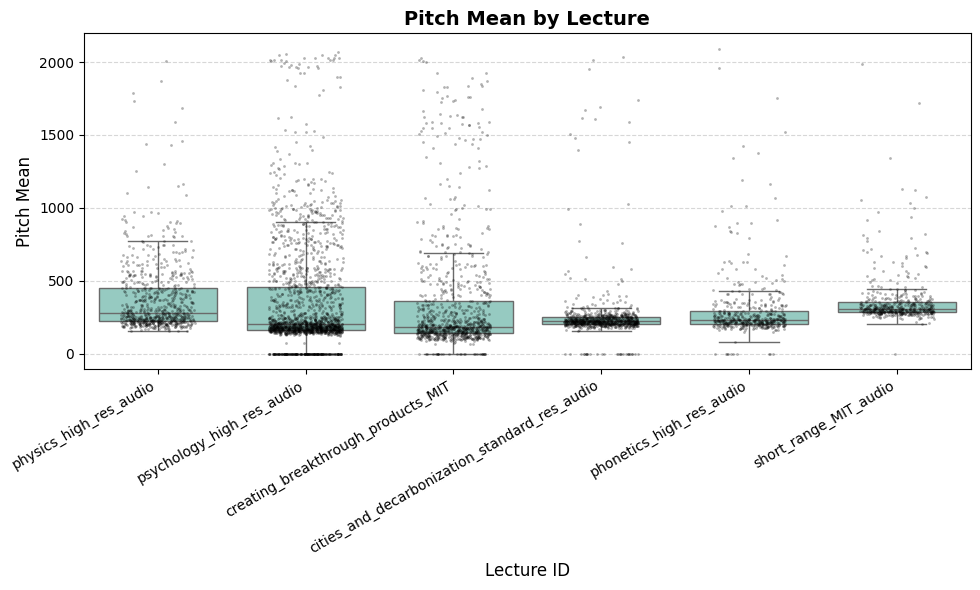

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

def beautified_boxplot(df, feature, figsize=(10, 6)):
    plt.figure(figsize=figsize)
    sns.boxplot(x='lecture_id', y=feature, data=df, color='#8dd3c7', showfliers=False)


    sns.stripplot(x='lecture_id', y=feature, data=df,
                  color='black', alpha=0.3, jitter=0.25, size=2)

    plt.xticks(rotation=30, ha='right', fontsize=10)
    plt.yticks(fontsize=10)
    plt.title(f"{feature.replace('_', ' ').title()} by Lecture", fontsize=14, weight='bold')
    plt.xlabel("Lecture ID", fontsize=12)
    plt.ylabel(feature.replace('_', ' ').title(), fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

# Example usage
beautified_boxplot(merged_df, 'pitch_mean')


Prosodic Features
(Pitch & Energy distributions + temporal trend)

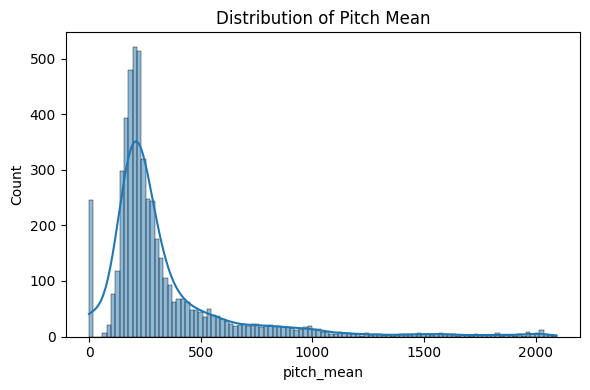

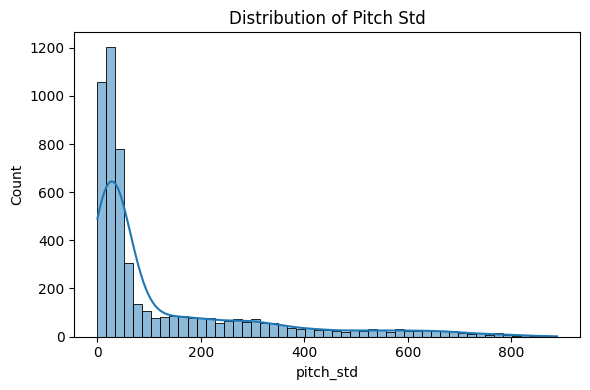

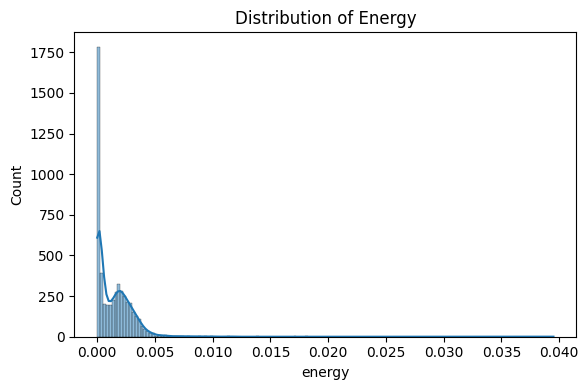

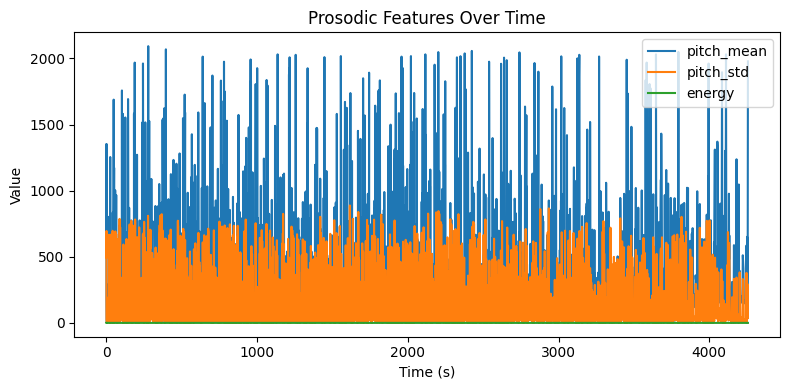

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_prosodic(df):
    prosodic = ['pitch_mean', 'pitch_std', 'energy']

    # 1a. Distribution
    for feat in prosodic:
        plt.figure(figsize=(6,4))
        sns.histplot(df[feat].dropna(), kde=True)
        plt.title(f"Distribution of {feat.replace('_',' ').title()}")
        plt.xlabel(feat)
        plt.ylabel("Count")
        plt.tight_layout()
        plt.show()

    # 1b. Temporal Trend (over time)
    df_sorted = df.sort_values('start')
    plt.figure(figsize=(8,4))
    for feat in prosodic:
        plt.plot(df_sorted['start'], df_sorted[feat], label=feat)
    plt.legend()
    plt.title("Prosodic Features Over Time")
    plt.xlabel("Time (s)")
    plt.ylabel("Value")
    plt.tight_layout()
    plt.show()

# Example:
plot_prosodic(merged_df)


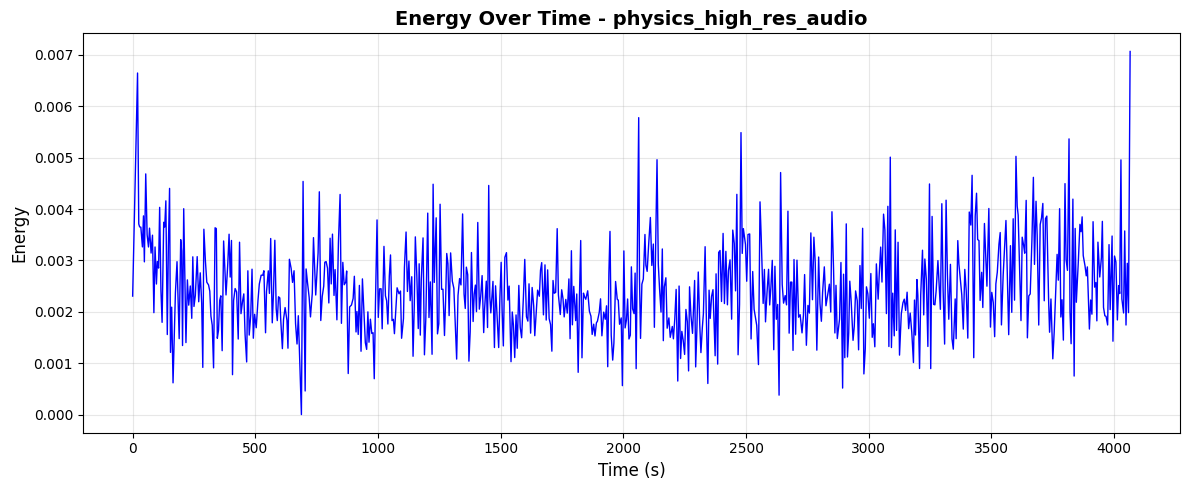

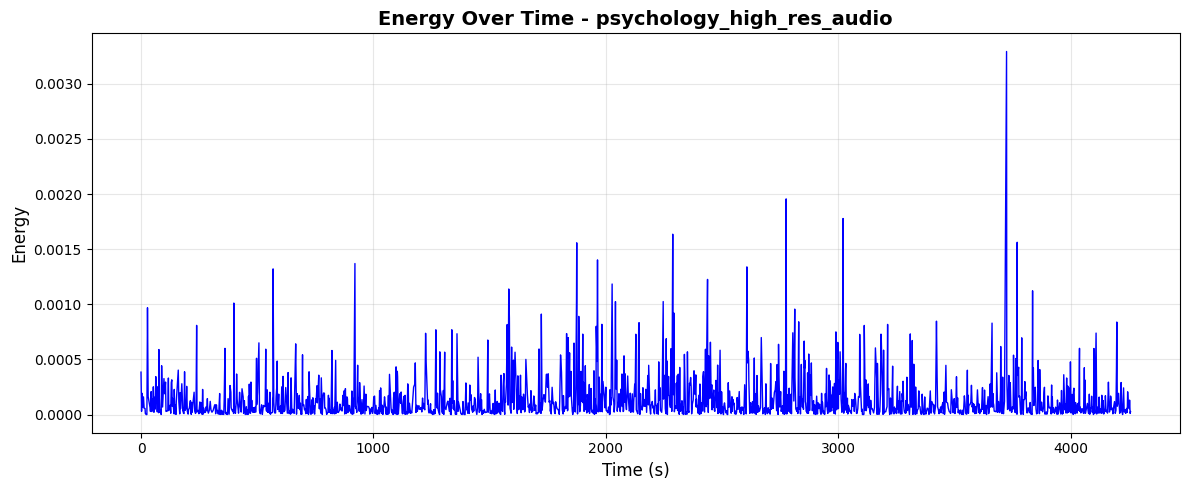

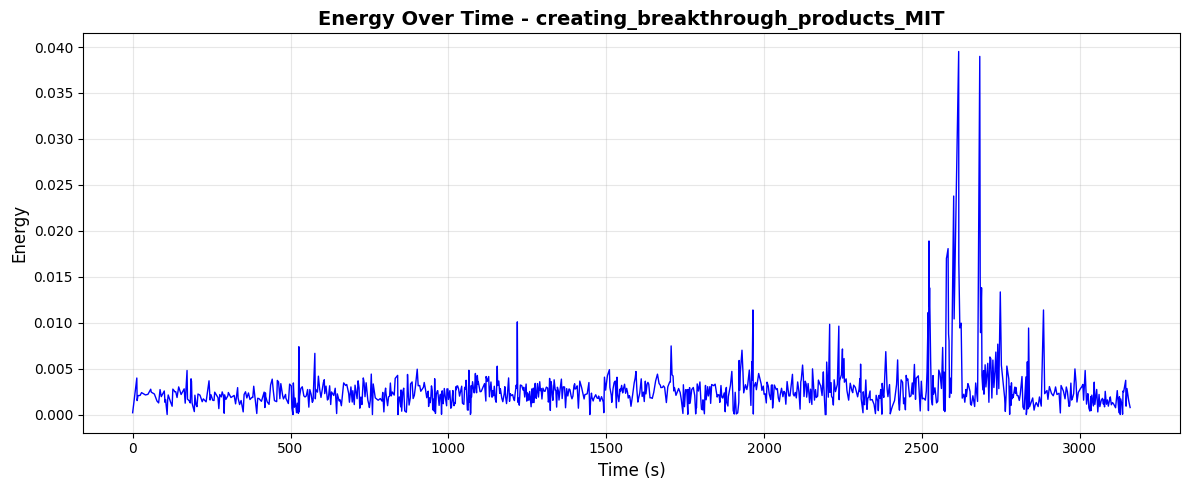

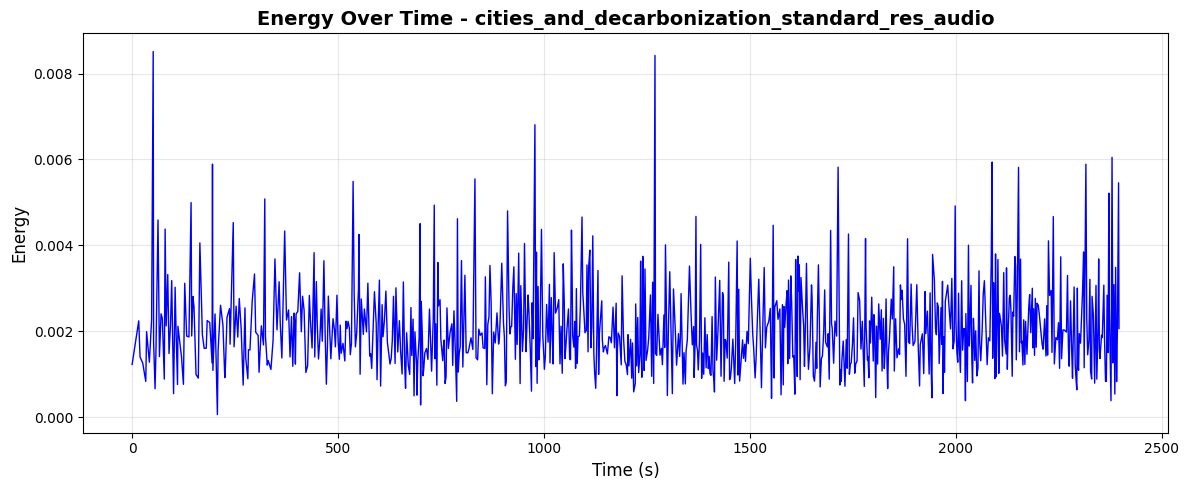

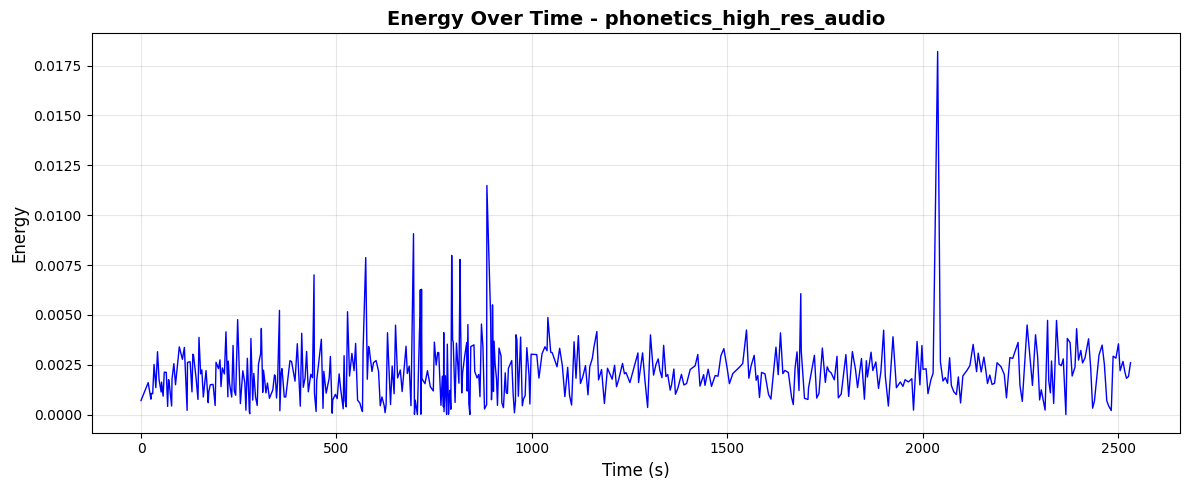

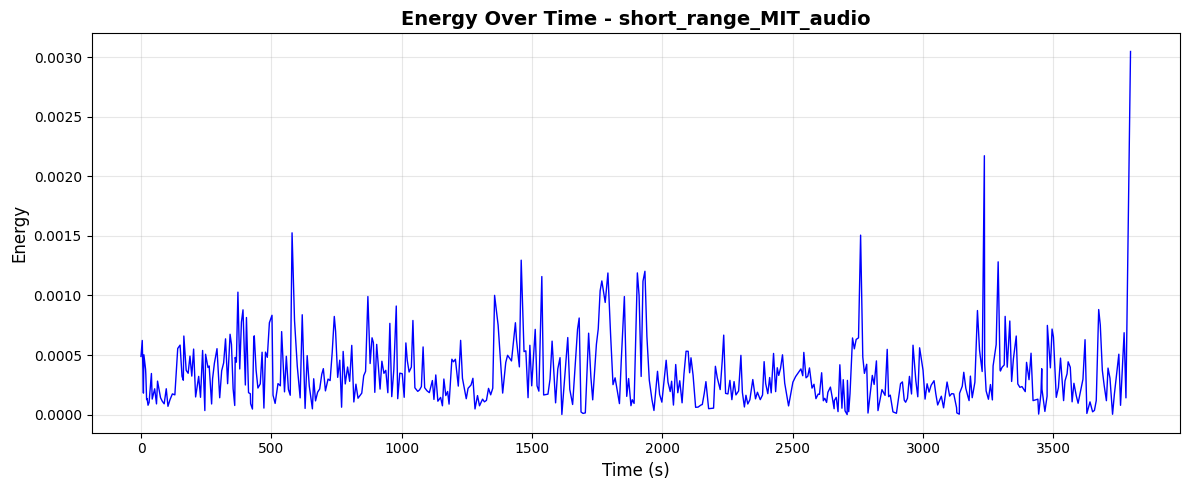

In [10]:
import matplotlib.pyplot as plt

def plot_energy_per_lecture(df):
    """
    Plot energy over time for each lecture individually.
    """
    lectures = df['lecture_id'].unique()

    for lec in lectures:
        lec_df = df[df['lecture_id'] == lec].sort_values('start')

        plt.figure(figsize=(12, 5))
        plt.plot(
            lec_df['start'], lec_df['energy'], label=f'Energy for {lec}', color='b', linewidth=1 )

        plt.title(f"Energy Over Time - {lec}", fontsize=14, weight='bold')
        plt.xlabel("Time (s)", fontsize=12)
        plt.ylabel("Energy", fontsize=12)
        plt.grid(alpha=0.3)
        plt.tight_layout()
        plt.show()

# Usage:
plot_energy_per_lecture(merged_df)


Phonation Features
(Jitter, Shimmer, HNR boxplots per lecture)

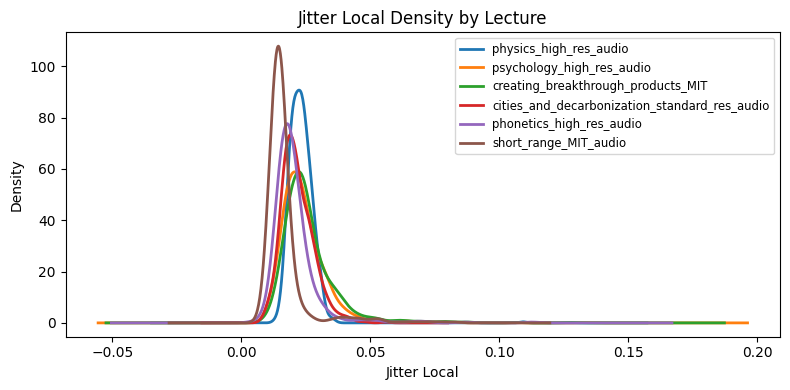

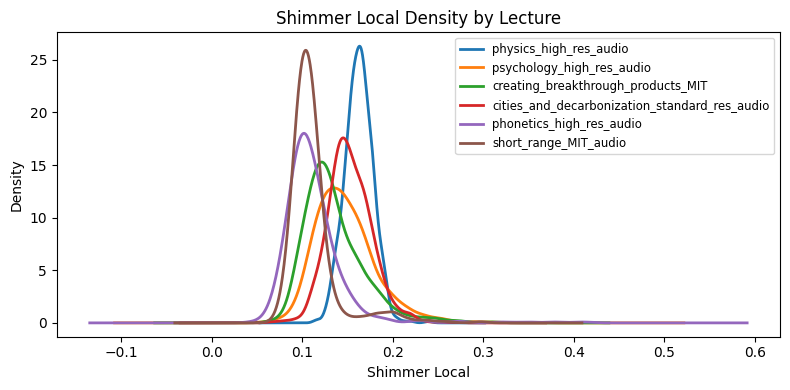

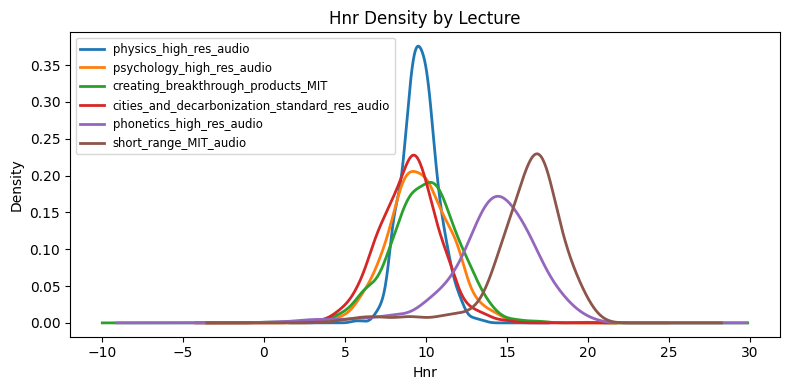

In [11]:
import matplotlib.pyplot as plt

def phonation_histograms(df):
    phon_feats = ['jitter_local', 'shimmer_local', 'hnr']

    for feat in phon_feats:
        plt.figure(figsize=(8,4))
        for lec in df['lecture_id'].unique():
            lec_df = df[df['lecture_id'] == lec]
            lec_df[feat].dropna().plot(
                kind='kde', linewidth=2, label=lec
            )
        plt.title(f"{feat.replace('_',' ').title()} Density by Lecture")
        plt.xlabel(feat.replace('_',' ').title())
        plt.ylabel("Density")
        plt.legend(loc='best', fontsize='small')
        plt.tight_layout()
        plt.show()

# Usage:
phonation_histograms(merged_df)


 MFCC Analysis
(Heatmap of MFCC correlations + individual distributions)

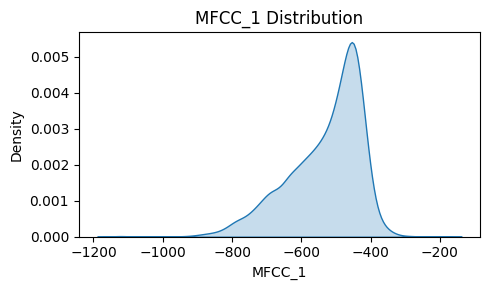

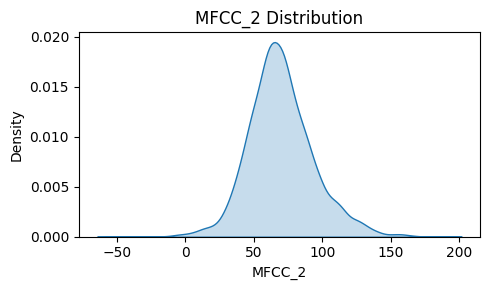

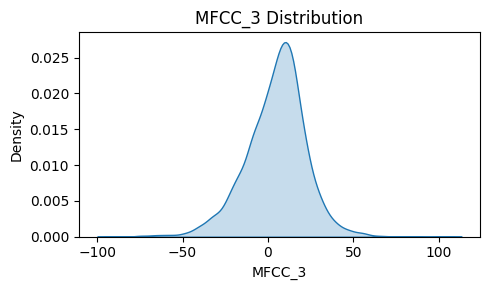

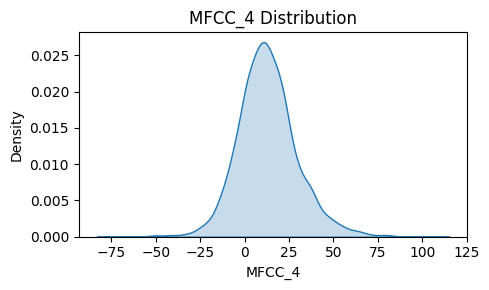

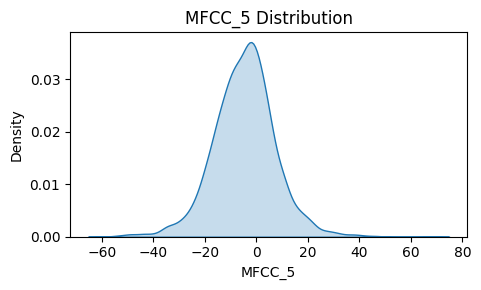

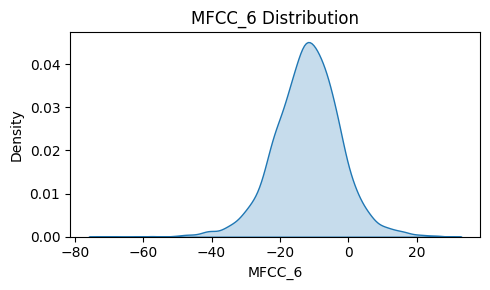

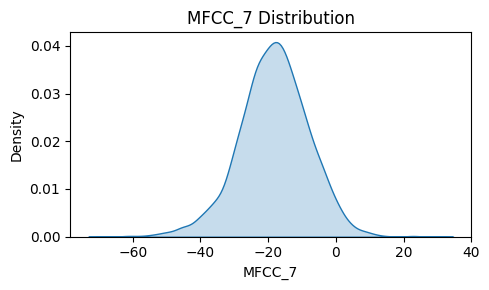

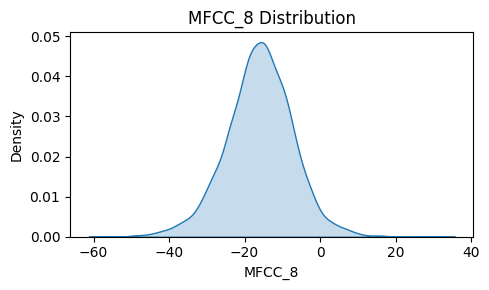

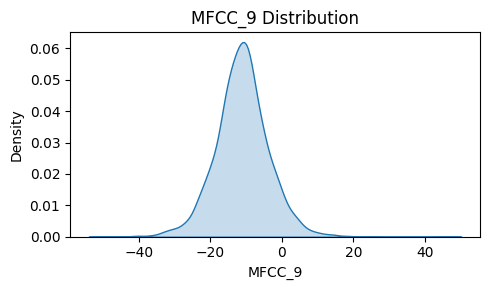

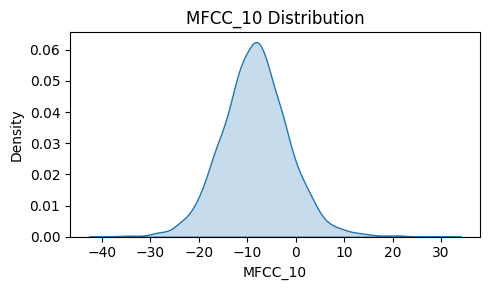

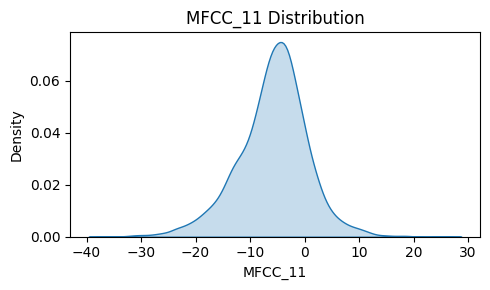

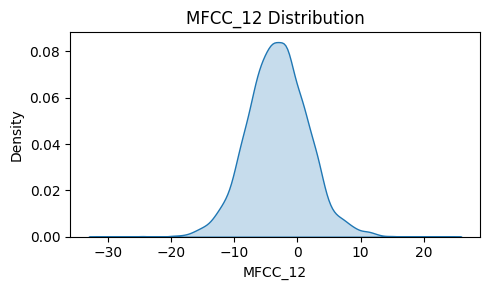

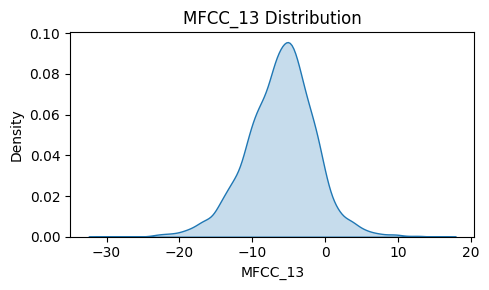

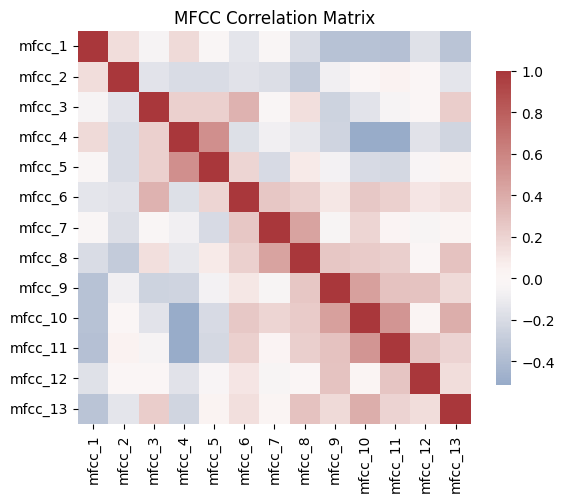

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_mfcc(df):
    mfccs = [f"mfcc_{i}" for i in range(1, 14)]

    # 5a. Distributions (KDE with fill)
    for feat in mfccs:
        plt.figure(figsize=(5, 3))
        sns.kdeplot(df[feat].dropna(), fill=True, common_norm=False)
        plt.title(f"{feat.upper()} Distribution")
        plt.xlabel(feat.upper())
        plt.ylabel("Density")
        plt.tight_layout()
        plt.show()

    # 5b. Correlation heatmap
    corr = df[mfccs].corr()
    plt.figure(figsize=(6, 5))
    sns.heatmap(corr, cmap='vlag', center=0, square=True, cbar_kws={'shrink': .8})
    plt.title("MFCC Correlation Matrix")
    plt.tight_layout()
    plt.show()

plot_mfcc(merged_df)


Speaking Rate and Articulation Rate Over Time

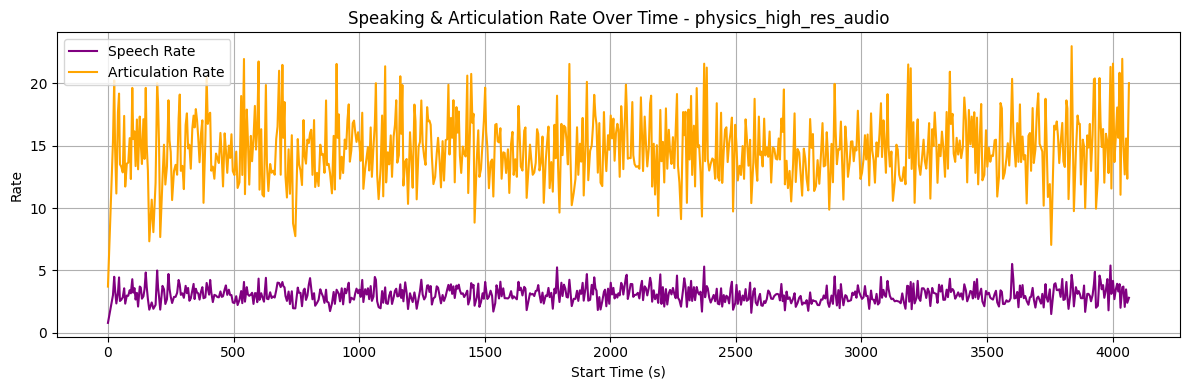

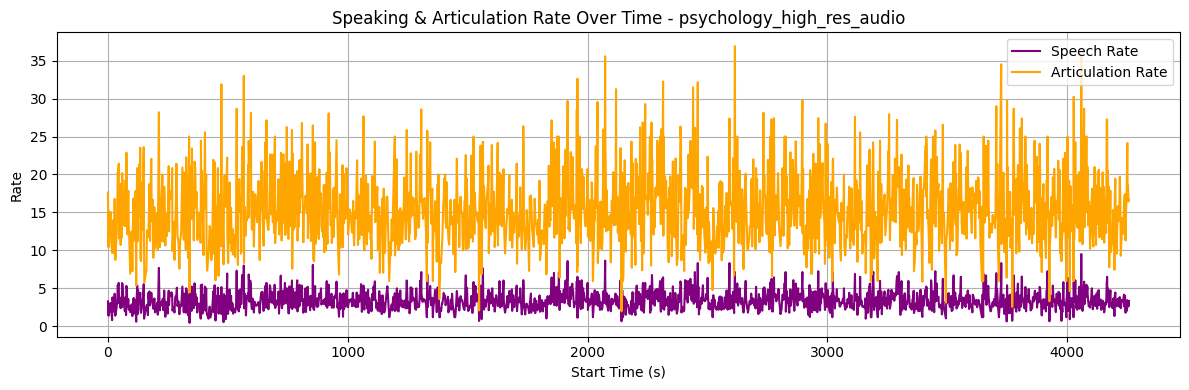

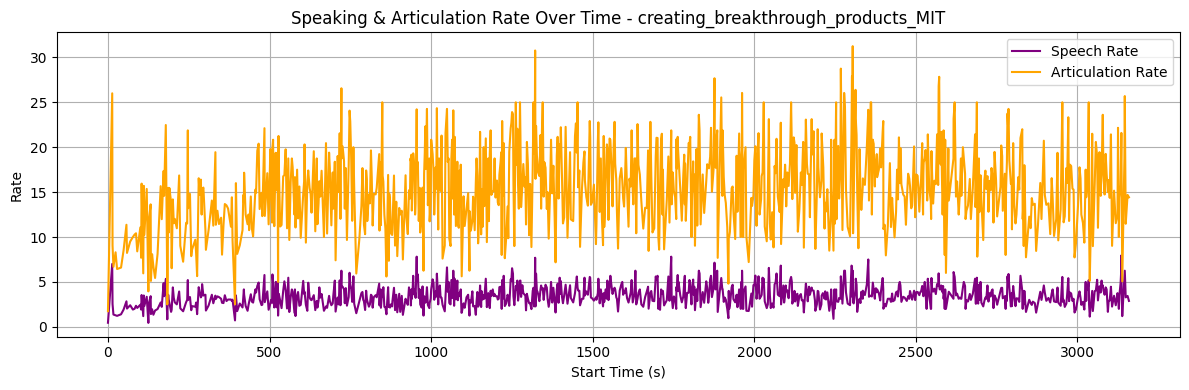

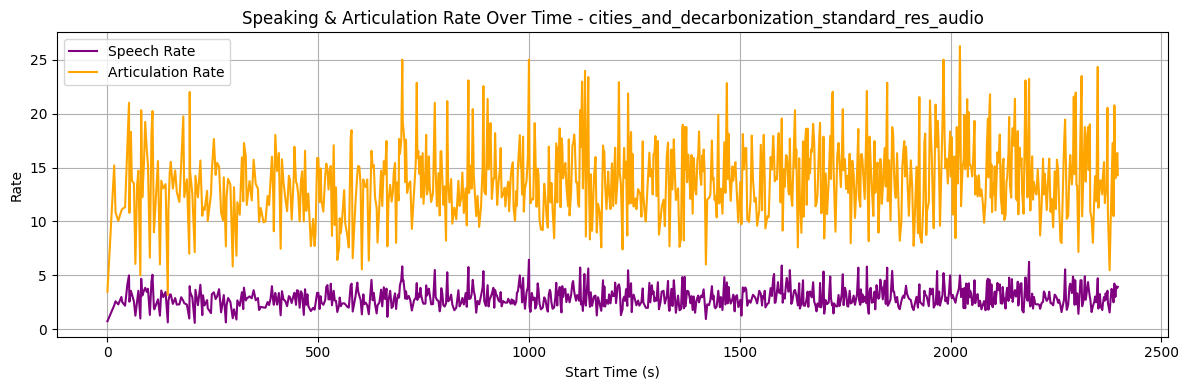

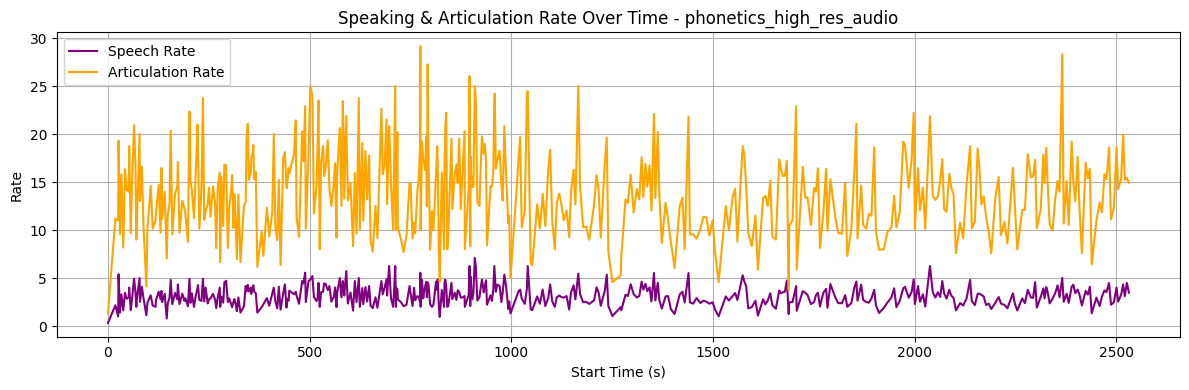

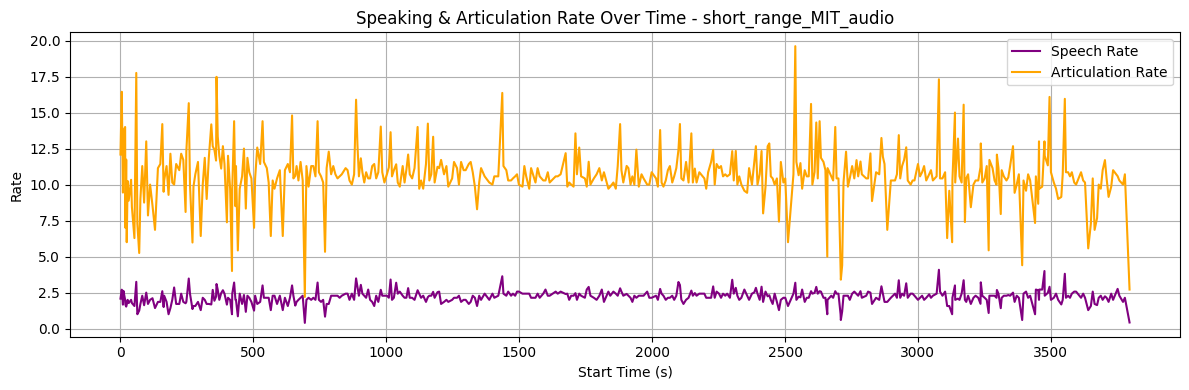

In [13]:
def plot_speaking_articulation_rate(df):
    """
    Plot speaking rate and articulation rate over time, split by lecture.
    """
    for lec in df['lecture_id'].unique():
        lec_df = df[df['lecture_id'] == lec].sort_values('start')

        plt.figure(figsize=(12, 4))
        plt.plot(lec_df['start'], lec_df['speech_rate'], label='Speech Rate', color='purple')
        plt.plot(lec_df['start'], lec_df['articulation_rate'], label='Articulation Rate', color='orange')
        plt.title(f"Speaking & Articulation Rate Over Time - {lec}")
        plt.xlabel("Start Time (s)")
        plt.ylabel("Rate")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

# Usage:
plot_speaking_articulation_rate(merged_df)


 Energy Dynamics (Change Over Time)

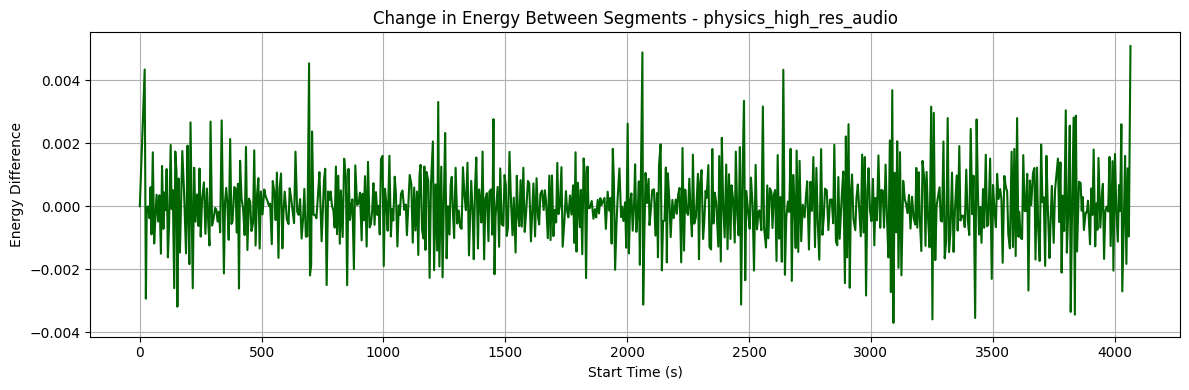

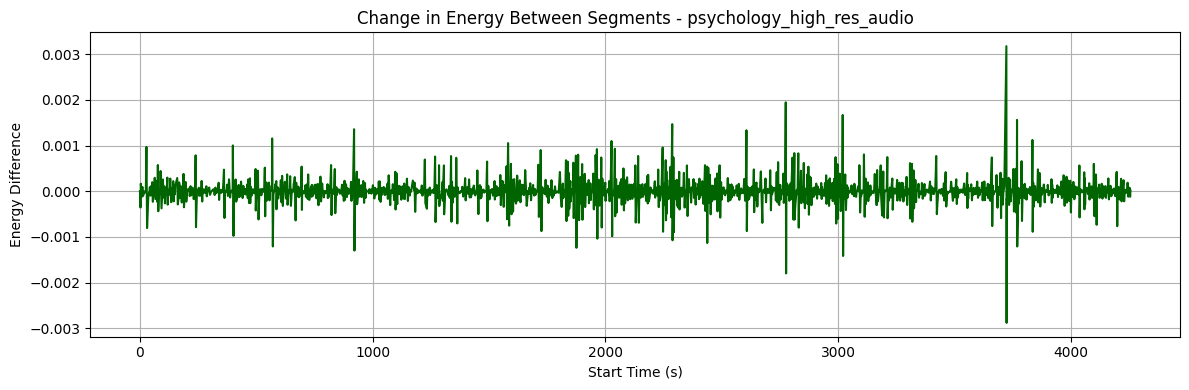

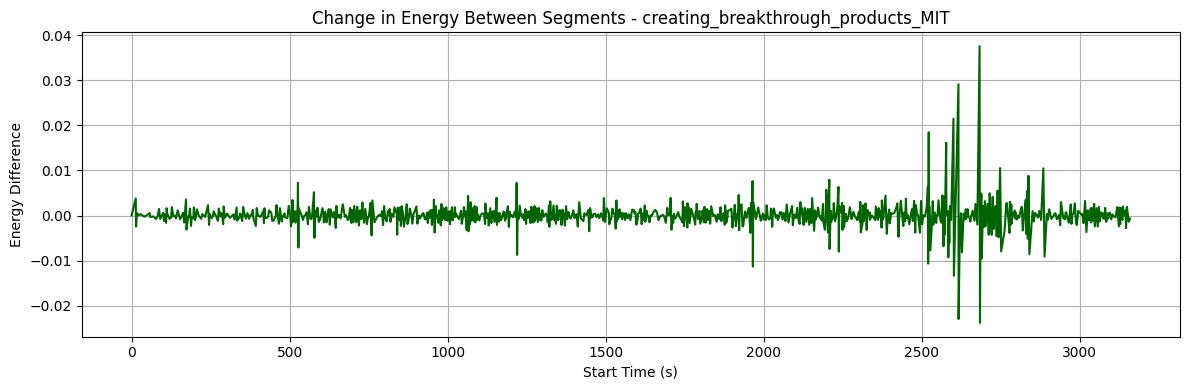

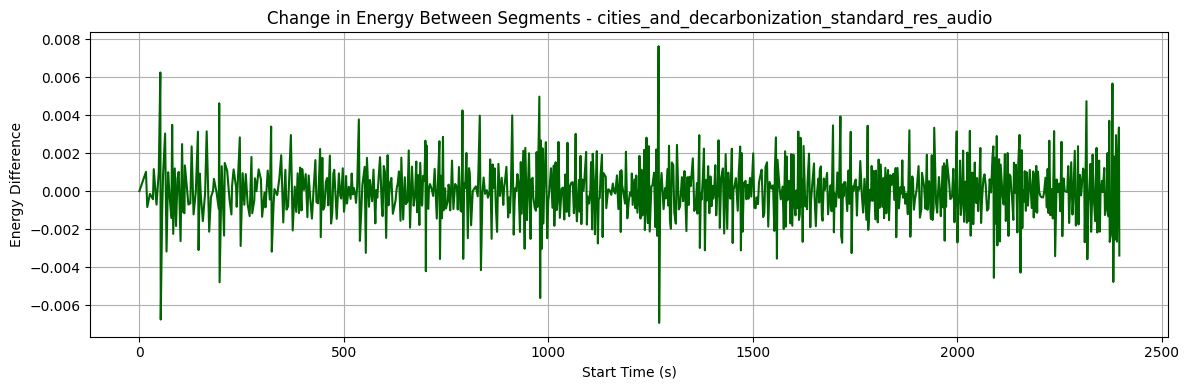

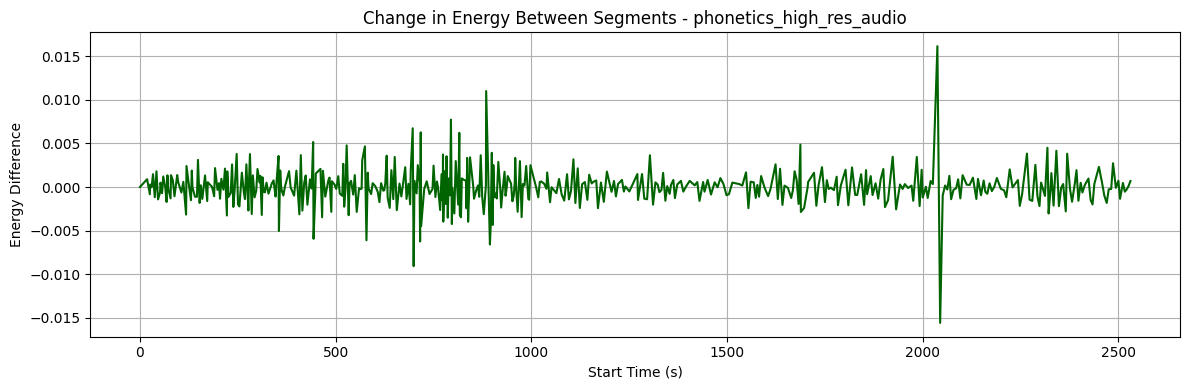

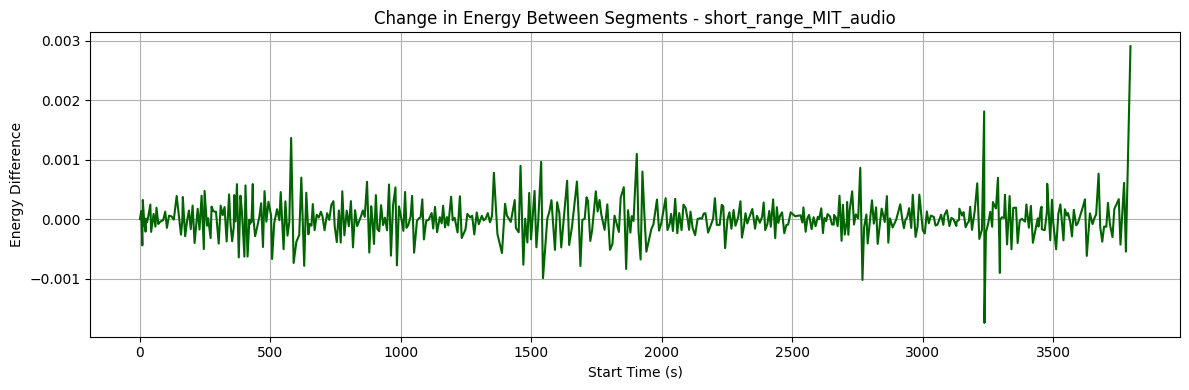

In [14]:
def plot_energy_diff(df):
    """
    Plot energy dynamics (change in energy) over time for each lecture.
    """
    for lec in df['lecture_id'].unique():
        lec_df = df[df['lecture_id'] == lec].copy()  # Ensure we're working with a copy

        lec_df.loc[:, 'energy_diff'] = lec_df['energy'].diff().fillna(0)  # Use .loc to avoid warning

        plt.figure(figsize=(12, 4))
        plt.plot(lec_df['start'], lec_df['energy_diff'], color='darkgreen')
        plt.title(f"Change in Energy Between Segments - {lec}")
        plt.xlabel("Start Time (s)")
        plt.ylabel("Energy Difference")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

# Usage:
plot_energy_diff(merged_df)


# **Extractive Summarization**

In [15]:
import pandas as pd
import numpy as np
import torch
from sentence_transformers import SentenceTransformer, util
from sklearn.preprocessing import MinMaxScaler

# Load your data
merged_df = pd.read_csv("/content/merged_segment_features.csv")

# 1) Normalize speech features
speech_features = ["energy", "pitch_mean", "hnr", "speech_rate", "formant_F1", "num_words"]
scaler = MinMaxScaler()
merged_df[speech_features] = scaler.fit_transform(merged_df[speech_features])

# 2) Compute an importance score for each segment
merged_df["importance_score"] = (
    0.3 * merged_df["energy"] +
    0.2 * merged_df["pitch_mean"] +
    0.2 * merged_df["hnr"] +
    0.1 * merged_df["speech_rate"] +
    0.1 * merged_df["formant_F1"] +
    0.1 * merged_df["num_words"]
)

# 3) MMR function that stays on GPU
def mmr(doc_emb, sent_embs, sentences, top_n=100, diversity=0.6):
    sims_to_doc = util.cos_sim(sent_embs, doc_emb).squeeze(1).cpu().numpy()
    selected, selected_idxs = [], []

    while len(selected) < min(top_n, len(sentences)):
        if not selected:
            idx = int(np.argmax(sims_to_doc))
        else:
            # compute redundancy
            redundancies = util.cos_sim(
                sent_embs, sent_embs[selected_idxs]
            ).max(dim=1)[0].cpu().numpy()
            mmr_scores = (1 - diversity) * sims_to_doc - diversity * redundancies
            mmr_scores[selected_idxs] = -np.inf
            idx = int(np.argmax(mmr_scores))

        selected.append(sentences[idx])
        selected_idxs.append(idx)

    return selected

# 4) Load embedding model
model = SentenceTransformer("all-MiniLM-L6-v2")

# 5) Generate and print summaries, collect into a list
records = []
for lec in merged_df["lecture_id"].unique():
    lec_df = merged_df[merged_df["lecture_id"] == lec]

    # pick top 50% by importance
    top_n = int(len(lec_df) * 0.5)
    top_segs = lec_df.nlargest(top_n, "importance_score").sort_values("segment_id")
    sentences = top_segs["text"].dropna().tolist()

    if sentences:
        sent_embs = model.encode(sentences, convert_to_tensor=True)
        device = sent_embs.device
        doc_emb = model.encode(" ".join(sentences), convert_to_tensor=True).to(device)

        summary_sents = mmr(doc_emb, sent_embs, sentences, top_n=150, diversity=0.6)
        summary = " ".join(s.strip().capitalize() for s in summary_sents if s.strip())
    else:
        summary = ""

    # print only the summary
    print(f"\n✅ Extractive Summary for {lec}:\n{summary}\n")

    records.append({"lecture_id": lec, "extractive_summary": summary})



/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]


✅ Extractive Summary for physics_high_res_audio:
Thought he was doing, what some of maxwell's contemporaries, how they read that book in That first slide. so today we're going to start our kind of journey in earnest. we're Keep up with your students, keep up with the readings, because it's snowball otherwise. From the 1680s, translated into this more modern language throughout the 1700s by the french scholars Of different ways to read the different kinds of sources. and i guess i hope we today will Or appropriate day job or a career. so that was a very, very clear gender disparity, but a great Research. then you'd often write your monograph, your whole book about it, maybe deliver some fancy Systems. so this unit cell starts to change its rate of rotation. that changes speed at which Physics and in what kinds of settings, what institutions. so during the first half of the With junk. it's great. it looks like julia has very kindly compiled a bunch of questions from, Interest in nationa

In [28]:
# 6) Create a DataFrame of all summaries
summaries_df = pd.DataFrame(records)
summaries_df.head()

,lecture_id,extractive_summary
0,physics_high_res_audio,"Thought he was doing, what some of maxwell's c..."
1,psychology_high_res_audio,"So in the oliver sacks book, there's a story a..."
2,creating_breakthrough_products_MIT,Innovations. you can't continue to do all thes...
3,cities_and_decarbonization_standard_res_audio,It's particularly important to look at makai c...
4,phonetics_high_res_audio,"Today is phonetics, which means that today we ..."


# **Abstractive Summarization**

In [17]:
import pandas as pd
from transformers import BartForConditionalGeneration, BartTokenizer

# Assuming 'records' is the list containing lecture_id and extractive_summary
summary_df = pd.DataFrame(records)

# Load BART model for abstractive summarization
summarization_model = BartForConditionalGeneration.from_pretrained("facebook/bart-large-cnn")
tokenizer = BartTokenizer.from_pretrained("facebook/bart-large-cnn")

# Function to generate abstractive summary using BART
def generate_abstractive_summary(extractive_summary):
    # Tokenize the extractive summary
    inputs = tokenizer(extractive_summary, return_tensors="pt", max_length=1024, truncation=True)

    # Generate abstractive summary using BART
    summary_ids = summarization_model.generate(inputs["input_ids"], max_length=512, num_beams=6, length_penalty=1.5, early_stopping=True)

    # Decode the generated summary
    abstractive_summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    return abstractive_summary

# Apply abstractive summarization to each extractive summary in the DataFrame
summary_df['abstractive_summary'] = summary_df['extractive_summary'].apply(generate_abstractive_summary)

# Neatly print the summaries for each lecture
for index, row in summary_df.iterrows():
    print(f"Lecture ID: {row['lecture_id']}")
    print(f"Abstractive Summary:\n{row['abstractive_summary']}\n")
    print("="*100)


config.json:   0%|          | 0.00/1.58k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Lecture ID: physics_high_res_audio
Abstractive Summary:
From the 1680s, translated into this more modern language throughout the 1700s by the french scholars Of different ways to read the different kinds of sources. So that was a very, very clear gender disparity, but a great Research. Then you'd often write your monograph, your whole book about it, maybe deliver some fancy Systems.

Lecture ID: psychology_high_res_audio
Abstractive Summary:
Your support will help mit opencourseware continue to How normal are you when you do an experiment? The following content is provided under a creative There's more and more research around the world, Unusual single individuals who turn out to have a lesson You have, that'd be great, is kind of another thread of the Supports it.

Lecture ID: creating_breakthrough_products_MIT
Abstractive Summary:
Innovations. you can't continue to do all these minor things. Well, i know he's got such a topper there that you have to reevaluating yours. I'm astonished

# **Model Evaluation**

In [19]:
!pip install textstat

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.3/175.3 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 939.4/939.4 kB 34.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 84.5 MB/s eta 0:00:00


In [32]:
import pandas as pd
from textstat import textstat

# If you haven’t already, load the extractive summaries:
# summary_df = pd.read_csv("lecture_extractive_summaries.csv")

results_extractive = []
for _, row in summary_df.iterrows():
    summary = row['extractive_summary'] or ""
    fk    = textstat.flesch_kincaid_grade(summary)
    smog  = textstat.smog_index(summary)
    fog   = textstat.gunning_fog(summary)
    results_extractive.append({
        'lecture_id': row['lecture_id'],
        'flesch_kincaid_extractive': fk,
        'smog_index_extractive': smog,
        'gunning_fog_extractive': fog
    })

df_extractive_eval = pd.DataFrame(results_extractive)
df_extractive_eval



,lecture_id,flesch_kincaid_extractive,smog_index_extractive,gunning_fog_extractive
0,physics_high_res_audio,7.274642,10.202149,9.462280
1,psychology_high_res_audio,6.752708,9.988104,9.261329
2,creating_breakthrough_products_MIT,6.583862,9.806752,9.235239
3,cities_and_decarbonization_standard_res_audio,13.202156,12.951904,15.897950
4,phonetics_high_res_audio,6.215220,8.675015,8.767954
5,short_range_MIT_audio,11.825982,13.602022,14.830473


# **2) Abstractive Summary Readability**

In [37]:
import pandas as pd
from textstat import textstat

# If you haven’t already, load the abstractive summaries:
# summary_df = pd.read_csv("lecture_abstractive_summaries.csv")

results_abstractive = []
for _, row in summary_df.iterrows():
    summary = row['abstractive_summary'] or ""
    fk    = textstat.flesch_kincaid_grade(summary)
    smog  = textstat.smog_index(summary)
    fog   = textstat.gunning_fog(summary)
    results_abstractive.append({
        'lecture_id': row['lecture_id'],
        'flesch_kincaid_abstractive': fk,
        'smog_index_abstractive': smog,
        'gunning_fog_abstractive': fog
    })

df_abstractive_eval = pd.DataFrame(results_abstractive)
df_abstractive_eval


,lecture_id,flesch_kincaid_abstractive,smog_index_abstractive,gunning_fog_abstractive
0,physics_high_res_audio,9.367273,11.208143,10.242424
1,psychology_high_res_audio,14.363596,15.903189,17.014035
2,creating_breakthrough_products_MIT,5.813777,10.125757,9.806383
3,cities_and_decarbonization_standard_res_audio,6.937963,11.698219,11.325926
4,phonetics_high_res_audio,4.006389,5.985473,5.388889
5,short_range_MIT_audio,25.719032,17.122413,28.670968


In [44]:
import pandas as pd
from sentence_transformers import SentenceTransformer, util

# 1) Force CPU use
model = SentenceTransformer("all-MiniLM-L6-v2", device="cpu")

# 2) Compute semantic similarity on CPU
def compute_semantic_similarity(text1, text2):
    emb1 = model.encode(text1, convert_to_tensor=True, device="cpu")
    emb2 = model.encode(text2, convert_to_tensor=True, device="cpu")
    return util.cos_sim(emb1, emb2).item()

# 3) Loop over your summaries
evaluation_results = []
for _, row in summary_df.iterrows():
    lid = row['lecture_id']
    # assemble full lecture text
    lecture_text = merged_df[merged_df["lecture_id"] == lid]["text"].str.cat(sep=' ')
    ext_sum = row['extractive_summary'] or ""
    abs_sum = row['abstractive_summary'] or ""

    ext_sim = compute_semantic_similarity(lecture_text, ext_sum)
    abs_sim = compute_semantic_similarity(lecture_text, abs_sum)

    evaluation_results.append({
        'lecture_id': lid,
        'semantic_similarity_extractive': ext_sim,
        'semantic_similarity_abstractive': abs_sim
    })

evaluation_df = pd.DataFrame(evaluation_results)
evaluation_df


,lecture_id,semantic_similarity_extractive,semantic_similarity_abstractive
0,physics_high_res_audio,0.587242,0.234593
1,psychology_high_res_audio,0.668815,0.537644
2,creating_breakthrough_products_MIT,0.739676,0.608908
3,cities_and_decarbonization_standard_res_audio,0.634520,0.450196
4,phonetics_high_res_audio,0.592598,0.397455
5,short_range_MIT_audio,0.473312,0.541311


# **Notes Generation**

In [1]:
import pandas as pd
import re
import spacy
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sentence_transformers import SentenceTransformer
from transformers import pipeline

# 0) Force CPU usage
device = "cpu"
print(f"Using device: {device}")

# 1) Load spaCy
nlp = spacy.load("en_core_web_sm")

# 2) Initialize models on CPU
sentence_encoder = SentenceTransformer('all-mpnet-base-v2', device=device)
summarizer = pipeline(
    "summarization",
    model="facebook/bart-large-cnn",
    device=-1    # -1 == CPU
)

# 3) Helper functions
def calculate_key_concept_score(text):
    doc = nlp(text)
    noun_phrases = [chunk.text for chunk in doc.noun_chunks]
    unique_concepts = len(set(noun_phrases))
    total_words = len([token for token in doc if not token.is_punct])
    return unique_concepts / total_words if total_words > 0 else 0

def enhanced_clean_text(text):
    text = re.sub(
        r'\b(uh+|um+|like|you know|i mean|actually|basically|right|so|okay|kind of)\b',
        '', text, flags=re.IGNORECASE
    )
    text = re.sub(r'\s+([.,!?])(\s+|$)', r'\1 ', text).strip()
    text = re.sub(r'([.!?]){2,}', r'\1', text)
    text = re.sub(r'^[^a-zA-Z]+', '', text)

    doc = nlp(text)
    clean_sents = []
    for sent in doc.sents:
        s = sent.text.strip()
        if len(s.split()) < 4:
            continue
        s = s[0].upper() + s[1:]
        if not s.endswith(('.', '!', '?')):
            s += '.'
        clean_sents.append(s)
    return ' '.join(clean_sents) if clean_sents else None

def extract_semantic_features(text):
    emb = sentence_encoder.encode(
        text,
        convert_to_tensor=True,
        device=device,
        show_progress_bar=False
    )
    return emb.cpu().numpy()

def calculate_contextual_importance(row, acoustic_weight=0.6, semantic_weight=0.4):
    acoustic_score = (
        0.25 * row['energy'] +
        0.20 * row['pitch_mean'] +
        0.15 * row['hnr'] +
        0.15 * row['speech_rate'] +
        0.15 * row['formant_F1'] +
        0.10 * row['num_words']
    )
    semantic_score = row['semantic_coherence'] * 0.7 + row['key_concept_score'] * 0.3
    return (acoustic_weight * acoustic_score) + (semantic_weight * semantic_score)

def generate_coherent_notes(df, top_n=10, min_sentence_length=12):
    notes = {}
    for lecture_id in df["lecture_id"].unique():
        lecture_df = df[df["lecture_id"] == lecture_id].copy()

        # compute key concept density
        lecture_df["key_concept_score"] = lecture_df["cleaned_text"].apply(calculate_key_concept_score)

        # semantic embeddings
        lecture_df["semantic_embeddings"] = lecture_df["cleaned_text"].apply(extract_semantic_features)
        embs = np.vstack(lecture_df["semantic_embeddings"].values)

        # PCA + coherence
        pca = PCA(n_components=3)
        pcs = pca.fit_transform(embs)
        lecture_df[["emb_pc1","emb_pc2","emb_pc3"]] = pcs
        lecture_df["semantic_coherence"] = lecture_df["semantic_embeddings"].apply(
            lambda x: np.mean(np.dot(x, embs.T))
        )

        # compute hybrid importance
        lecture_df["importance_score"] = lecture_df.apply(calculate_contextual_importance, axis=1)

        # pick diverse top segments
        selected, seen = [], set()
        for _, row in lecture_df.sort_values("importance_score", ascending=False).iterrows():
            if len(selected) >= top_n * 1.5:
                break
            chunks = [c.text for c in nlp(row["cleaned_text"]).noun_chunks if len(c.text.split())>1]
            if not chunks or any(c not in seen for c in chunks):
                selected.append(row)
                seen.update(chunks)

        sel_df = pd.DataFrame(selected).sort_values("segment_id").head(top_n)
        raw_notes = sel_df["cleaned_text"].tolist()

        # summarizer on CPU
        summary = summarizer(
            "\n".join(raw_notes),
            max_length=150,
            min_length=40,
            do_sample=False
        )[0]["summary_text"]
        bullets = [
            f"- {s.strip().capitalize()}."
            for s in summary.split(". ")
            if len(s.split()) >= min_sentence_length
        ][:top_n]

        notes[lecture_id] = bullets

    return notes

def process_lecture_notes(input_csv):
    df = pd.read_csv(input_csv)

    # clean & normalize
    df["cleaned_text"] = df["text"].apply(enhanced_clean_text)
    df = df.dropna(subset=["cleaned_text"])
    scaler = MinMaxScaler()
    feats = ["energy","pitch_mean","hnr","speech_rate","formant_F1","num_words"]
    df[feats] = scaler.fit_transform(df[feats])

    notes = generate_coherent_notes(df)
    for lid, bullets in notes.items():
        print(f"\n📚 Notes for {lid}:\n" + "\n".join(bullets) + "\n" + "="*60)
    return notes

if __name__ == "__main__":
    process_lecture_notes("/content/merged_segment_features.csv")


Using device: cpu


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.4k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.58k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Device set to use cpu
Your max_length is set to 150, but your input_length is only 113. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=56)
Your max_length is set to 150, but your input_length is only 98. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=49)
Your max_length is set to 150, but your input_length is only 122. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=61)



📚 Notes for physics_high_res_audio:
- He introduces these things which we still use to this day,  lines of force and then fields.
- Thought he was doing, what some of maxwell's contemporaries, how they read that book in..

📚 Notes for psychology_high_res_audio:
- If the father is in his 50s, that would be a very interesting path.
- We tend to think, who do we think about big decisions? or partner, or whatever.

📚 Notes for creating_breakthrough_products_MIT:
- "all of a sudden we were 400 people and we were designing this stuff," he says.

📚 Notes for cities_and_decarbonization_standard_res_audio:
- Makai titles his book, sustainable energy without the hot air, what we're trying to do.
- We're going to measure energy in terms of units of kilowatt hours..

📚 Notes for phonetics_high_res_audio:
- For s, it's  coining it front, my alveolar ridge, and then for shh, the middle.
- That's the place that your tongue is touching when you say the sounds of the beginnings of words..

📚 Notes for